# Accompanying notebook to Optimization Stories in Logistics and Transportation
By Joaquim Gromicho, ORTEC & The Analytics Academy, 2020

In [1]:
import numpy
import scipy.spatial
import requests
import time
from pyomo.opt import SolverFactory
import pyomo.environ as pyo
import matplotlib.pyplot as plt

%matplotlib inline

## TSP models

The **Dantzig, Fulkerson and Johnson** model considers the decision variables: 
$$
   x_{ij} = \left\{
     \begin{array}{lr}
       1 & \mbox{if node } j \mbox{ follows node } i \\
       0 & \mbox{otherwise}                          \\
     \end{array}
   \right.
$$
and formulates the TSP as:
$$
\begin{array}{rrcll}
\min    & \sum_{i,j \in N} c_{ij}x_{ij} \\
s.t.    & \sum_{i \in N} x_{ij}              & =    & 1     & \forall j \in N                       \\
        & \sum_{j \in N} x_{ij}              & =    & 1     & \forall i \in N                       \\
        & \sum_{i \in S, j \not\in S} x_{ij} & \geq & 1     & \forall \emptyset \subset S \subset N \\
        & x_{ij} \in \{0,1\}                 &      &       & \forall i, j \in N                    \\
\end{array}
$$

Equivalently, the model can also be expressed as:
$$
\begin{array}{rrcll}
\min    & \sum_{i,j \in N} c_{ij}x_{ij} \\
s.t.    & \sum_{i \in N} x_{ij}   & =    & 1     & \forall j \in N                       \\
        & \sum_{j \in N} x_{ij}   & =    & 1     & \forall i \in N                       \\
        & \sum_{i,j \in S} x_{ij} & \leq & |S|-1 & \forall \emptyset \subset S \subset N \\
        & x_{ij} \in \{0,1\}      &      &       & \forall i, j \in N                    \\
\end{array}
$$

Since this model requires an exponential number of constraints we prefer to start with a more compact model. 

Fortunately, a [compact](https://en.wikipedia.org/wiki/Travelling_salesman_problem#Miller-Tucker-Zemlin_formulation) model exists. 
This ingenious model, devised by C. E. Miller, Alfred E. Tucker and R. A. Zemlin in 1960 adds _sequence_ variables $u_i$ and replace the connectivity (also known as subtour elimination) constraints which are in a exponential number by circa $n^2$ sequence constraints. 

$$
\begin{array}{rrcll}
\min    & \sum_{i,j \in N} c_{ij}x_{ij} \\
s.t.    & \sum_{i \in N} x_{ij} & =    & 1    & \forall j \in N                              \\
        & \sum_{j \in N} x_{ij} & =    & 1    & \forall i \in N                              \\
        & x_{ij} \in \{0,1\}    &      &      & \forall i, j \in N                           \\
        & u_i - u_j + nx_{ij}   & \leq & n-1  & \forall i,j \in N : 2 \leq i \not = j \leq n \\
        & u_i \in [0,n-1]       &      &      & \forall i \in N                              \\
\end{array}
$$

In [2]:
def SolveLocally( model, solver ):
    s = time.time()
    results = SolverFactory(solver).solve(model)
    print( time.time()-s )
    print( results.solver.status, results.solver.termination_condition )
    print( model.obj.expr() )
    return model, results

In [3]:
def GenerateTSP( n=10, seed = 2020 ):
    numpy.random.seed( seed )
    instance = {}
    instance['NAME'] = 'n=' + str(n) + ' seed=' + str(seed)
    instance['NODE_COORD_SECTION'] = [ [i+1,numpy.random.randint( 100 ),numpy.random.randint( 100 ) ] for i in range(n) ]
    return instance

In [4]:
def GetCostMatrix( instance ):
    X = numpy.asmatrix( instance['NODE_COORD_SECTION'] )[:,1:] 
    c = scipy.spatial.distance_matrix( X, X )
    return numpy.round(c,0).astype(int)

In [5]:
instance = GenerateTSP(8)

In [6]:
C = GetCostMatrix(instance)
C

array([[ 0, 66,  7, 54, 78, 66, 22, 45],
       [66,  0, 68, 12, 42, 55, 58, 58],
       [ 7, 68,  0, 57, 77, 63, 18, 41],
       [54, 12, 57,  0, 43, 50, 47, 49],
       [78, 42, 77, 43,  0, 24, 60, 43],
       [66, 55, 63, 50, 24,  0, 45, 23],
       [22, 58, 18, 47, 60, 45,  0, 23],
       [45, 58, 41, 49, 43, 23, 23,  0]])

In [7]:
def BipartiteMatching( C ):
    n = C.shape[0]

    model = pyo.ConcreteModel("Igor")    

    model.nodes = pyo.RangeSet( 0, n-1 )
    model.cost  = pyo.Param( model.nodes, model.nodes, initialize = lambda model, i,j : C[i][j] )
    model.x     = pyo.Var( model.nodes, model.nodes, within = pyo.Binary )

    model.obj = pyo.Objective( expr = sum( model.cost[i,j]*model.x[i,j] for i in model.nodes for j in model.nodes ), sense=pyo.minimize )

    def leave_rule( model, i ):
        return sum( model.x[i,j] for j in model.nodes ) == 1

    def enter_rule( model, j ):
        return sum( model.x[i,j] for i in model.nodes ) == 1

    model.leave = pyo.Constraint( model.nodes, rule = leave_rule )
    model.enter = pyo.Constraint( model.nodes, rule = enter_rule )
    
    return model

In [8]:
model = BipartiteMatching( C )
model,results = SolveLocally( model, 'glpk' )

0.4087095260620117
ok optimal
0.0


In [9]:
def GetValuesOfArcVariables( model ):
    return [ [ round(model.x[i,j].value) for j in model.nodes ] for i in model.nodes ]

In [10]:
GetValuesOfArcVariables( model )

[[1, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 1]]

In [11]:
def EliminateDiagonal( model ):
    model.move = pyo.Constraint( expr = sum( model.x[i,i] for i in model.nodes ) == 0 )
    return model

model = EliminateDiagonal( model )

model,results = SolveLocally( model, 'glpk' )

GetValuesOfArcVariables( model )

0.16755270957946777
ok optimal
132.0


[[0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 1, 0]]

In [12]:
def MTZ( model ):
    model.u = pyo.Var( model.nodes, within=pyo.NonNegativeReals )

    def mtz_rule( model, i, j ):
        n = len(model.nodes)
        if i > 0 and j > 0 and i != j: 
            return model.u[i] - model.u[j] + model.x[i,j] * n <= n-1
        else:
            return model.u[i] == model.u[i]
    
    model.mtz = pyo.Constraint( model.nodes, model.nodes, rule = mtz_rule ); 
    return model

In [13]:
model = MTZ(model)
model,results = SolveLocally( model, 'glpk' )

GetValuesOfArcVariables( model )

0.19137048721313477
ok optimal
203.0


[[0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1, 0, 0]]

In [14]:
def AsSequenceOfNodes( model ):
    successor = [ j for i in model.nodes for j in model.nodes if model.x[i,j].value > 0.5 ]
    solution  = [0]
    solution.append(successor[solution[-1]])
    while solution[-1] != solution[0]:
        solution.append(successor[solution[-1]])
    return solution

In [15]:
AsSequenceOfNodes( model )

[0, 2, 6, 7, 5, 4, 1, 3, 0]

In [16]:
def GetRouteCost( route, C ):
    departure = route[:-1]
    arrival = route[1:]
    return sum(C[departure,arrival])

In [17]:
def GetCoordinates( instance ):
    data = numpy.asarray( instance['NODE_COORD_SECTION'] )
    X = data[:,1].astype(int)
    Y = data[:,2].astype(int)
    return X,Y

In [18]:
def ShowTSP( instance, sol=[], numbers=False, how='' ):
    
    X, Y = GetCoordinates( instance )

    C = GetCostMatrix( instance )
    n = len( C )
    if len( sol ) == n:
        sol.append( sol[0] )
        
    markersize = 15 if numbers else 3
    
    plt.plot( X[sol], Y[sol], 'g-' )
    plt.plot( X,Y, 'ro', markersize=markersize )
    if numbers:
        for i in range(n):
            plt.annotate( "{:d}".format(i), ( X[i],Y[i] ), ha="center", va="center", color = 'w', fontsize=10 )
    if len(sol) > 0:
        plt.plot( X[sol[0]],Y[sol[0]], 'yo', markersize=markersize )    
        if numbers:
            plt.annotate( "{:d}".format(sol[0]), ( X[sol[0]],Y[sol[0]] ), ha="center", va="center", color = 'r', fontsize=10 )
        
    if len(sol) > 0:
        plt.plot( X[sol[0]],Y[sol[0]], 'yo' )    
    
    plt.gca().set_xlabel('x')
    plt.gca().set_ylabel('y')

    plt.title( '{:s} #{:d} ${:d} {:s}'.format( instance['NAME'], len(X), GetRouteCost( sol, C ), how ) )
    
    plt.axis('equal')

    plt.show()

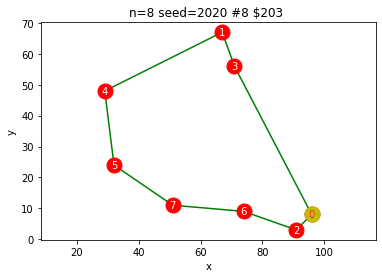

In [19]:
ShowTSP( instance, AsSequenceOfNodes(model), numbers=True )

In [20]:
def VeryWeakTSP( C ):
    return MTZ( EliminateDiagonal( BipartiteMatching( C ) ) )

In [21]:
model,results = SolveLocally( VeryWeakTSP(GetCostMatrix(instance = GenerateTSP(20))), 'gurobi' )

5.453559637069702
ok optimal
361.0


## How to read benchmarks

Note, however, that the models in this notebook are unsuited for serious instances! 

In [22]:
def ReadTextFromURL( url ):
    return requests.get( url ).text

In [23]:
def NumberOrString( text ):
    if ( text.isdigit() ):
        return int(text)
    elif ( text.replace('.','',1).isdigit() ):
        return float(text)
    else:
        return text

In [24]:
def LeftPart( lineWithColon ):
    return lineWithColon.split(':')[0].strip()

In [25]:
def RightPart( lineWithColon ):
    return NumberOrString(lineWithColon.split(':',1)[1].strip())

In [26]:
def ParseComment( comment ):
    asList = comment.replace('(','').replace(')','').split(',') 
    result = { LeftPart(line) : RightPart(line) for line in asList if ':' in line }
    result[ 'COMMENT' ] = ",".join( [ line for line in asList if not ':' in line ] )
    return result

In [27]:
def Dispatch(name, *args, **kwargs):
    dispatcher = {'DIMENSION':int, 'CAPACITY':int, 'COMMENT':ParseComment}
    if name in dispatcher.keys(): 
        return dispatcher[name](*args, **kwargs)    
    else:
        return NumberOrString(*args, **kwargs)

In [28]:
def ReadCVRP( text ):
    lines = [ line for line in text.split('\n') if len(line) > 0 ]
    if ( not 'EOF' in lines[-1] ):
        lines.append( 'EOF' )
    instance = { LeftPart(line) : Dispatch(LeftPart(line),RightPart(line)) for line in lines if ':' in line }
    nofCols = {'NODE_COORD_SECTION':3, 'DEMAND_SECTION':2, 'DEPOT_SECTION':1}
    idxSections = [ i for i, line in enumerate(lines) if 'SECTION' in line or 'EOF' in line ]
    for i,idx in enumerate(idxSections[:-1]):
        key = lines[idx].strip()
        nof = nofCols[key]
        instance[ key ] = [ [NumberOrString(x) for x in line.split()] for line in lines[idx+1:idxSections[i+1]] ]
    return instance

http://www.math.uwaterloo.ca/tsp/world/djtour.html

In [29]:
instance = ReadCVRP( ReadTextFromURL( 'http://www.math.uwaterloo.ca/tsp/world/dj38.tsp' ))

In [30]:
model,results = SolveLocally( VeryWeakTSP(GetCostMatrix(instance)), 'cplex' )

12.62692666053772
ok optimal
6656.0


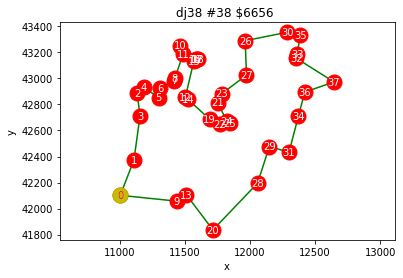

In [31]:
ShowTSP( instance, AsSequenceOfNodes(model), numbers=True )